# Метод $k$ ближайших соседей

Идея данного метода машинного обучения базируется на **гипотезе компактности** [1].

**Гипотеза компактности** — в задачах классификации предположение о том, что схожие объекты гораздо чаще лежат в одном классе, чем в разных; или, другими словами, что классы образуют компактно локализованные подмножества в пространстве объектов. Это также означает, что граница между классами имеет достаточно простую форму.

Для формализации понятия "сходство" вводится функция расстояния или метрика $\rho(x,x')$ в пространстве признаков $X$.

In [5]:
#import warnings; warnings.simplefilter('ignore')
%pylab inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})

Populating the interactive namespace from numpy and matplotlib


## Задача о раковых больных

В качестве примера задачи для демонстрации метода $k$ ближайших соседей рассмотрим набор данных для решения задачи об наличии болезни у пациента.

In [6]:
from sklearn.datasets import load_breast_cancer

ds = load_breast_cancer()

print(ds.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Для упрощения задачи в плане визуаизации признакового пространства оставим тольок 2 признака в описании:
* радиус - признак №0
* текстура - признак №1.

In [7]:
X = ds.data[:,0:2]
y = ds.target

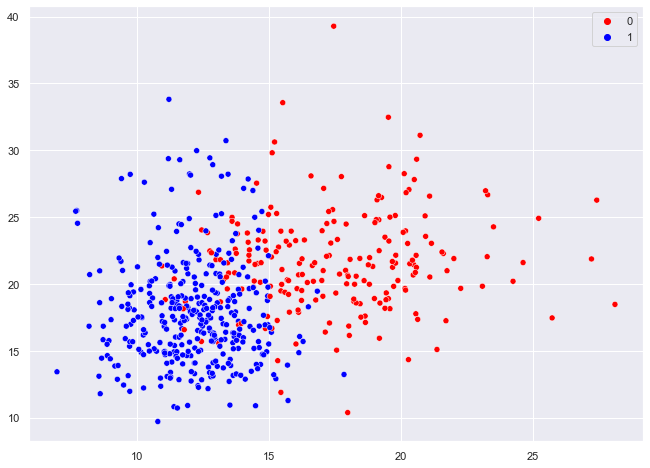

In [13]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['red', 'blue']);

### Разделение выборки на обучающую и проверочную

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обобщенный метрический классификатор 

Пусть заданы:
* $X$ - объекты, $Y$ - ответы,
* $S = (x_i,  y_i)_{i=1}^n$ - обучающая выборка.
* функция расстояния $\rho: X \times X \to [0, \infty)$. 

**Пример.** Евклидово расстояние и его обобщение
$$ \rho(x_i, x_k) = \left(\sum\limits_{j=1}^{n}(x_i^j - x_k^j)^2\right)^{1/2},\;  \rho(x_i, x_k) = \left(\sum\limits_{j=1}^{n}w_j(x_i^j - x_k^j)^p\right)^{1/p}.
$$



Для произвольного объекта $x$ отранжируем объекты $x_1,\dots, x_n$:
$$
\rho(x, x^{(1)}) \le \rho(x, x^{(2)}) \le \dots \le \rho(x, x^{(n)}),
$$
* $x^{(i)}$ - $i$-й сосед объекта $x$ среди $x_1, \dots, x_n$.

**Метрический алгоритм классификации:**
$$
a(x, S) = \arg\max_{y \in Y} \underbrace{\sum\limits_{i=1}^n\left[y^{(i)}=y\right]w(i, x)}_{\Gamma_y(x)},
$$
* $y^{(i)}$ - ответ на $i$-м соседе $x$,
* $w(i,x)$ - вес (степень важности) $i$-го соседа объекта $x$,
* $\Gamma_y(x)$ - оценка близости объекта $x$ к классу $y$.

### Метод ближайшего соседа

$$
w(i, x) = [i=1].
$$
**Преимущества:**
* простота реализации;
* интерпретируемость решений, вывод на основе прецедентов (case-based reasoning, CBR).

**Недостатки:**
* неустойчивость к погрешностям (шуму, выбросам);
* отсутсвие настраиваемых параметров;
* низкое качество классификации;
* приходится хранить всю выборку целиком.

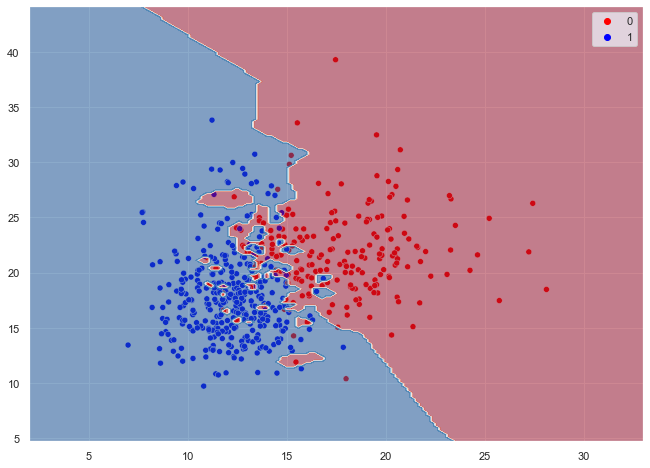

In [12]:
from sklearn.neighbors import KNeighborsClassifier

single_nn_clf = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

h = 0.2 # step in mesh
margin = 5 # mesh margin

ax = sns.scatterplot(x=X[:, 0],y=X[:, 1], hue=y, palette=['red', 'blue']);
cm = plt.cm.RdBu

x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = single_nn_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.5);

In [14]:
from sklearn.metrics import accuracy_score

y_pred = single_nn_clf.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print("Single kNN accuracy score: {:.3f}".format(acc_score))

Single kNN accuracy score: 0.883


### Метод $k$ ближайших соседей

$$
w(i, x) = [i \le k].
$$

**Преимущества:**
* менее чувствителен к шуму; 
* появился параметр 𝑘.

**Оптимизация числа соседей 𝑘:** функционал скользящего контроля leave-one-out
$$
LOO(k, S) = \sum\limits_{i=1}^{n}\left[a(x_i; S\setminus\{x_i\}; k) \ne y_i\right] \rightarrow \min_k.
$$

**Проблема:**
неоднозначность классификации при $\Gamma_y(x) = \Gamma_s(x), y \ne s$.

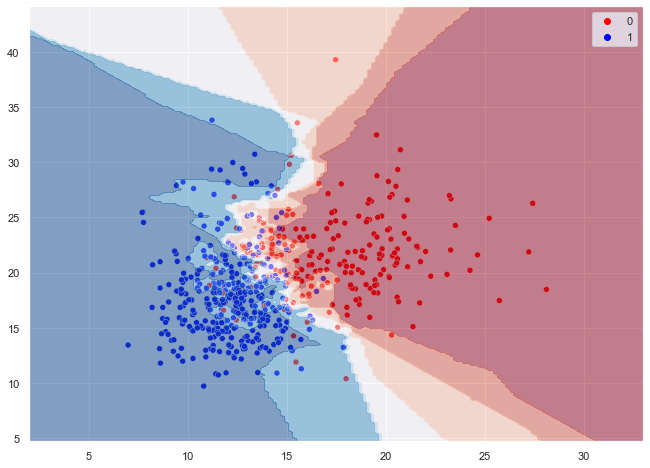

In [15]:

knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['red', 'blue']);
Z = knn_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.5);

In [16]:
y_pred = knn_clf.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print("kNN accuracy score: {:.3f}".format(acc_score))

kNN accuracy score: 0.877


### Подбор числа соседей

Подбор оптимального числа соседей можно организовать с помощью тестовой выборки. 

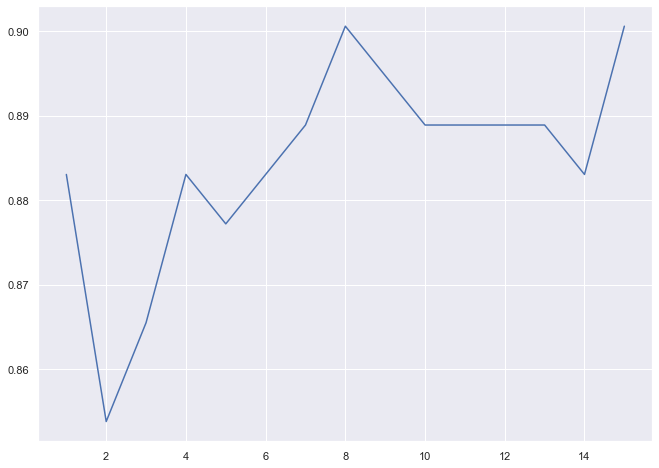

In [17]:
k_range = np.arange(1, 16)
acc_scores = list()
for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    
    y_pred = knn_clf.predict(X_test)
    
    acc_scores.append(accuracy_score(y_test, y_pred))

plot(k_range, acc_scores);

In [18]:
print("Наилучшее значение k = {}".format(k_range[np.argmax(acc_scores)]))

Наилучшее значение k = 8


## Метод $k$ взвешенных ближайших соседей

$$w(i, x) = [i \le k]w_i,$$
где $w_i$ - вес, зависящий только от номера соседа;

**Возможные эвристики:**
* $w_i = \frac{k+1-i}{k}$ - линейно убывающие веса;
* $w_i = q^i$ - экспоненциально убывающие веса, $0 < q < 1$.

**Проблемы:**
* как обоснованно задавать веса?
* возможно, было бы лучше, если вес $w(i, x)$ зависал не от порядкового номера соседа $i$, а от расстояния до него $\rho(x, x^{(i)})$.

## Метод окна Парзена

$w(i, x) = K(\frac{\rho(x, x^{(i)})}h)$, где $h$ - ширина окна, $K(r)$ - ядро, не возрастает и положительно на $[0, 1]$.

**Метод парзеновского окна фиксированной ширины:**
$$a(x; S, h, K) = \arg\max_{y \in Y} \sum\limits_{i=1}^{n}[y_i = y]K(\frac{\rho(x, x_i)}{\color{red}{h}}).$$

**Метод парзеновского окна переменной ширины:**
$$a(x; S, h, K) = \arg\max_{y \in Y} \sum\limits_{i=1}^{n}[y_i = y]K(\frac{\rho(x, x_i)}{\color{red}{\rho(x, x^{(k+1)}}}).$$

**Оптимизация параметров:**
* выбор ширины окна $h$ или числа соседей $k$;
* выбор ядра $K$.

## Часто используемые ядра

* $R(x) = 0.5[|x| \ge 1]$ - прямоугольное;
* $T(x) = (1 - |x|)[|x| \ge 1]$ - треугольное;
* $E(x) = 0.75(1-x^2)[|x| \ge 1]$ - ядра Епанечникова;
* $Q(x) = 15/16(1-x^2)^2[|x| \ge 1]$ - квадратичное;
* $G(x) = \frac{1}{\sqrt{2\pi}}\exp\left(-x^2/2\right)$ - ядро Гаусса.

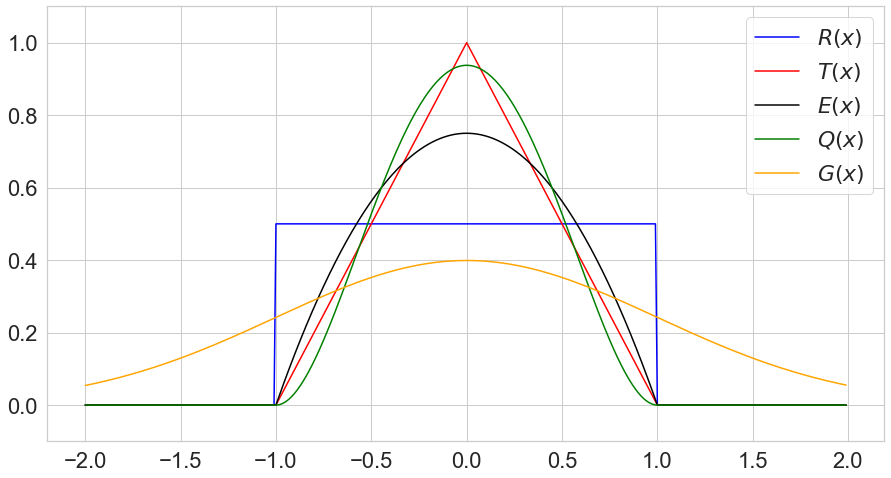

In [19]:
def H(x):
    return np.array([0 if xi <=0 else 1 for xi in x])

x = np.arange(-2, 2, 0.01)
plt.figure(figsize=(15,8))
sns.set(font_scale=2)
sns.set_style("whitegrid")
plt.plot(x, 0.5*(H(x + 1) - H(x - 1)), label='$R(x)$', color='blue')
plt.plot(x, (1 - np.abs(x))*(H(x + 1) - H(x - 1)), label='$T(x)$', color='red')
plt.plot(x, 0.75*(1 - np.power(x, 2))*(H(x + 1) - H(x - 1)), label='$E(x)$', color='black')
plt.plot(x, 15.0/16.0*np.power(1 - np.power(x, 2), 2)*(H(x + 1) - H(x - 1)), label='$Q(x)$', color='green')
plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-np.power(x, 2)/2), label='$G(x)$', color='orange')
plt.ylim((-0.1, 1.1))
plt.legend();

## Подбор размера окна $h$

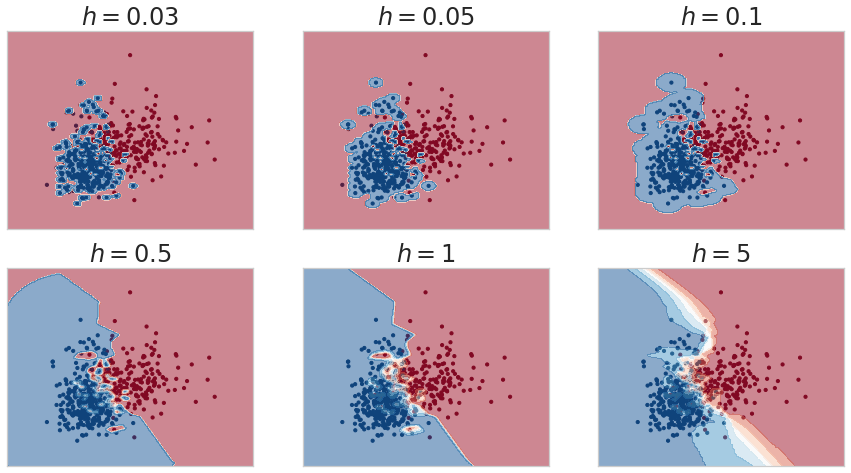

In [20]:
def knn_weights(h):
    def fun(distances):
        return np.exp(-2*np.power(distances/h, 2))
    return fun

h = [0.03, 0.05, 0.1, 0.5, 1, 5]
n_neibors = 5

plt.figure(figsize=(15,8))
for i, window in enumerate(h):
    ax = plt.subplot(2, 3, i + 1)
    clf = KNeighborsClassifier(n_neibors, weights=knn_weights(window)).fit(X_train, y_train)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cm)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.5)
    ax.set_title("$h = {}$".format(window))
    ax.set_xticks(())
    ax.set_yticks(())

## Литература
1. Гипотеза компактности, url - http://www.machinelearning.ru/wiki/index.php?title=Гипотеза_компактности
2. **К.В. Воронцов**, Метрические методы классификации, url - https://youtu.be/l1xGQMowWA4